## Update Anomaly_maps_decoder

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from anomaly_qwen2_5_vl import Anomaly_Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor
from qwen_vl_utils import process_vision_info

best_ckpt_path = '../ckpts/step006800.pth'
print(f"\n正在加载最佳权重: {best_ckpt_path}")

base = Anomaly_Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "../Geo/Anomaly_Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)
processor = Qwen2_5_VLProcessor.from_pretrained("../Geo/Anomaly_Qwen2.5-VL-7B-Instruct")
print(base.model.anomaly_maps_decoder)
print(base.model.anomaly_maps_decoder)

state_dict = torch.load(best_ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = base.model.anomaly_maps_decoder.load_state_dict(state_dict, strict=False)
print("[Info] missing:", missing, '|', "[Info] unexpected:", unexpected)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Normal batch: {'input_ids': torch.Size([1680, 21]), 'attention_mask': torch.Size([1680, 21])} 
Abnormal batch: {'input_ids': torch.Size([1680, 21]), 'attention_mask': torch.Size([1680, 21])}

正在加载最佳权重: ./ckpts/step006800.pth


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at Geo/Anomaly_Qwen2.5-VL-7B-Instruct were not used when initializing Anomaly_Qwen2_5_VLForConditionalGeneration: ['model.language_model.anomaly_maps_decoder.fuse_weights', 'model.language_model.anomaly_maps_decoder.mlps.0.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.0.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.0.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.0.model.2.weight', 'model.language_model.anomaly_maps_decoder.mlps.1.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.1.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.1.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.1.model.2.weight', 'model.language_model.anomaly_maps_decoder.mlps.2.model.0.bias', 'model.language_model.anomaly_maps_decoder.mlps.2.model.0.weight', 'model.language_model.anomaly_maps_decoder.mlps.2.model.2.bias', 'model.language_model.anomaly_maps_decoder.mlps.2.model.2.weight'

AnomalyHeatmap(
  (mlps): ModuleList(
    (0-4): 5 x MLP(
      (model): Sequential(
        (0): Linear(in_features=1280, out_features=1024, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=1024, out_features=3584, bias=True)
      )
    )
  )
)
AnomalyHeatmap(
  (mlps): ModuleList(
    (0-4): 5 x MLP(
      (model): Sequential(
        (0): Linear(in_features=1280, out_features=1024, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=1024, out_features=3584, bias=True)
      )
    )
  )
)
[Info] missing: [] | [Info] unexpected: []


## Val

In [19]:
# Messages containing a local video path and a text query
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": "./dataset/train/01_0136-336_359.mp4",  # truck
                # "video": "./dataset/train/01_0028-288_311.mp4",  # running
                # "video": "./dataset/train/04_0001-408_431.mp4",  # jumping
                # "video": "./dataset/train/07_0048-180_203.mp4",  # fighting
                "fps": 24.0,
            },
            {
                "type": "text",
                # "text": "Is there any anomaly in the video？"
                # "text": "Videoda herhangi bir anormallik var mı?"
                "text": "视频里有什么异常吗？"
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs, video_kwargs = process_vision_info(messages, return_video_kwargs=True)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    **video_kwargs,
)
inputs = inputs.to("cuda")

# Inference
generated_ids = base.generate(**inputs, max_new_tokens=512)
anomaly_maps = base.model.anomaly_maps
anomaly_prompt = base.model.anomaly_prompt_embeds
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [20]:
print(text)
print(base.model.video_embeds.shape)
print(anomaly_prompt.shape)  # (T*10, dim_out)
print(base.model.inputs_embeds.shape)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|video_pad|><|vision_end|><|anomaly_prompt_start|><|anomaly_prompt_pad|><|anomaly_prompt_end|>视频里有什么异常吗？<|im_end|>
<|im_start|>assistant

torch.Size([6324, 3584])
torch.Size([120, 3584])
torch.Size([1, 6473, 3584])


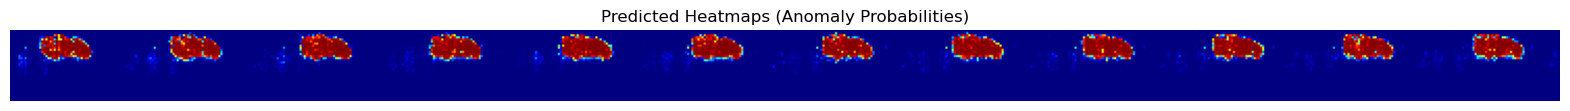

[System]>>>这段视频中没有明显的异常情况。视频显示了一辆小型货车在一条铺有砖块的道路上行驶，周围有一些行人。车辆看起来正常行驶，并没有出现失控或异常的情况。行人也都在正常行走，没有表现出恐慌或其他异常行为。整体环境看起来是一个普通的户外场景，没有明显的危险迹象。


In [21]:
T = anomaly_maps.shape[0]
vis_preds = []

# 获取softmax后的异常概率图 (取类别1表示异常的概率)
prob_maps = torch.softmax(anomaly_maps.float(), dim=1)[:, 1].cpu().detach().numpy()  # (B, H, W)

for i in range(T):
    heat = (prob_maps[i] * 255).astype(np.uint8)             # (H, W)
    pred_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)   # (H, W, 3)
    vis_preds.append(pred_color)

# 拼接所有帧为一行
row_pred = cv2.hconcat(vis_preds)

# OpenCV 是 BGR，需要转换为 RGB 才能显示正常
row_pred_rgb = cv2.cvtColor(row_pred, cv2.COLOR_BGR2RGB)

# 使用 matplotlib 显示
plt.figure(figsize=(20, 6))
plt.imshow(row_pred_rgb)
plt.axis('off')
plt.title("Predicted Heatmaps (Anomaly Probabilities)")
plt.show()

print("[System]>>>"+output_text[0])


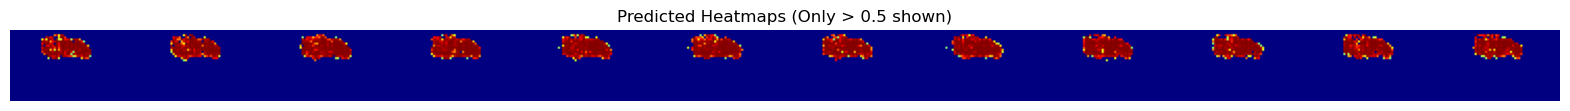

In [22]:
T = anomaly_maps.shape[0]
vis_preds = []

# 获取softmax后的异常概率图（取类别1为异常概率）
prob_maps = torch.softmax(anomaly_maps.float(), dim=1)[:, 1].cpu().detach().numpy()  # (B, H, W)

for i in range(T):
    prob = prob_maps[i]
    # 大于0.6保留，其他设为0
    prob_masked = np.where(prob > 0.5, prob, 0.0)
    # clip最大为1.0（其实本身就不会超）
    prob_masked = np.clip(prob_masked, 0, 1.0)
    # 转为可视化 [0,255]
    heat = (prob_masked * 255).astype(np.uint8)
    pred_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    # 把0的地方设为黑色（已经是黑的，可以省略这步）
    # pred_color[prob_masked == 0] = [0, 0, 0]
    vis_preds.append(pred_color)

# 拼接所有帧为一行
row_pred = cv2.hconcat(vis_preds)
row_pred_rgb = cv2.cvtColor(row_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 6))
plt.imshow(row_pred_rgb)
plt.axis('off')
plt.title("Predicted Heatmaps (Only > 0.5 shown)")
plt.show()
